In [2]:
%config IPCompleter.greedy=True
import warnings; warnings.simplefilter('ignore')

import random
import os
import time
import itertools
import collections
import scipy as sp
import pandas as pd
from cell import graph_utils, utils, math_utils, analysis, plot_utils
from stellargraph import StellarDiGraph
import cell.BiasedDirectedWeightedWalk as BDWW
from mpl_toolkits import mplot3d
import seaborn as sns


os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Reading the Inhibitory cAMP channels 

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


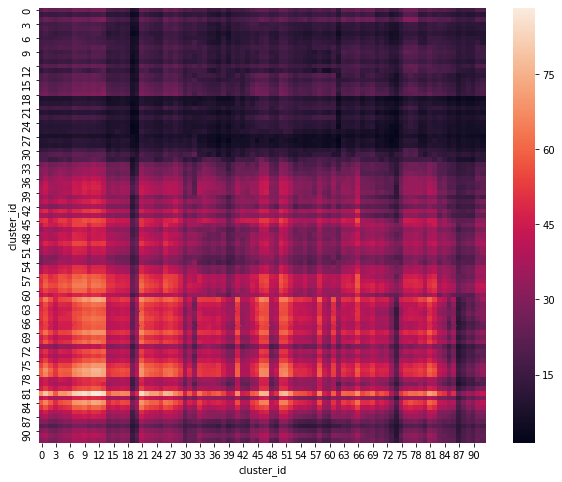

In [50]:
# %matplotlib qt5
cldf = utils.read_visp_npp_cldf("old")
layers = utils.get_npp_visp_layers(version="1.0")
#layers = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/NP_GPCR_pair_inh_cAMP.csv", header=None)[0].tolist()
int_mat = utils.read_npp_interaction_df(version="6.0", which_layers=layers, index=cldf.index, columns=cldf.index)
plt.figure(figsize=(10,8))
sns.heatmap(int_mat)

In [11]:
#np.argsort(-1 * int_mat.loc['92'])

In [51]:
# plt.figure(figsize=(10,8))
percentile = 0.3
not_normal_adj = graph_utils.keep_k_percentile_of_each_col_and_each_row(int_mat, percentile)
# sns.heatmap(not_normal_adj)

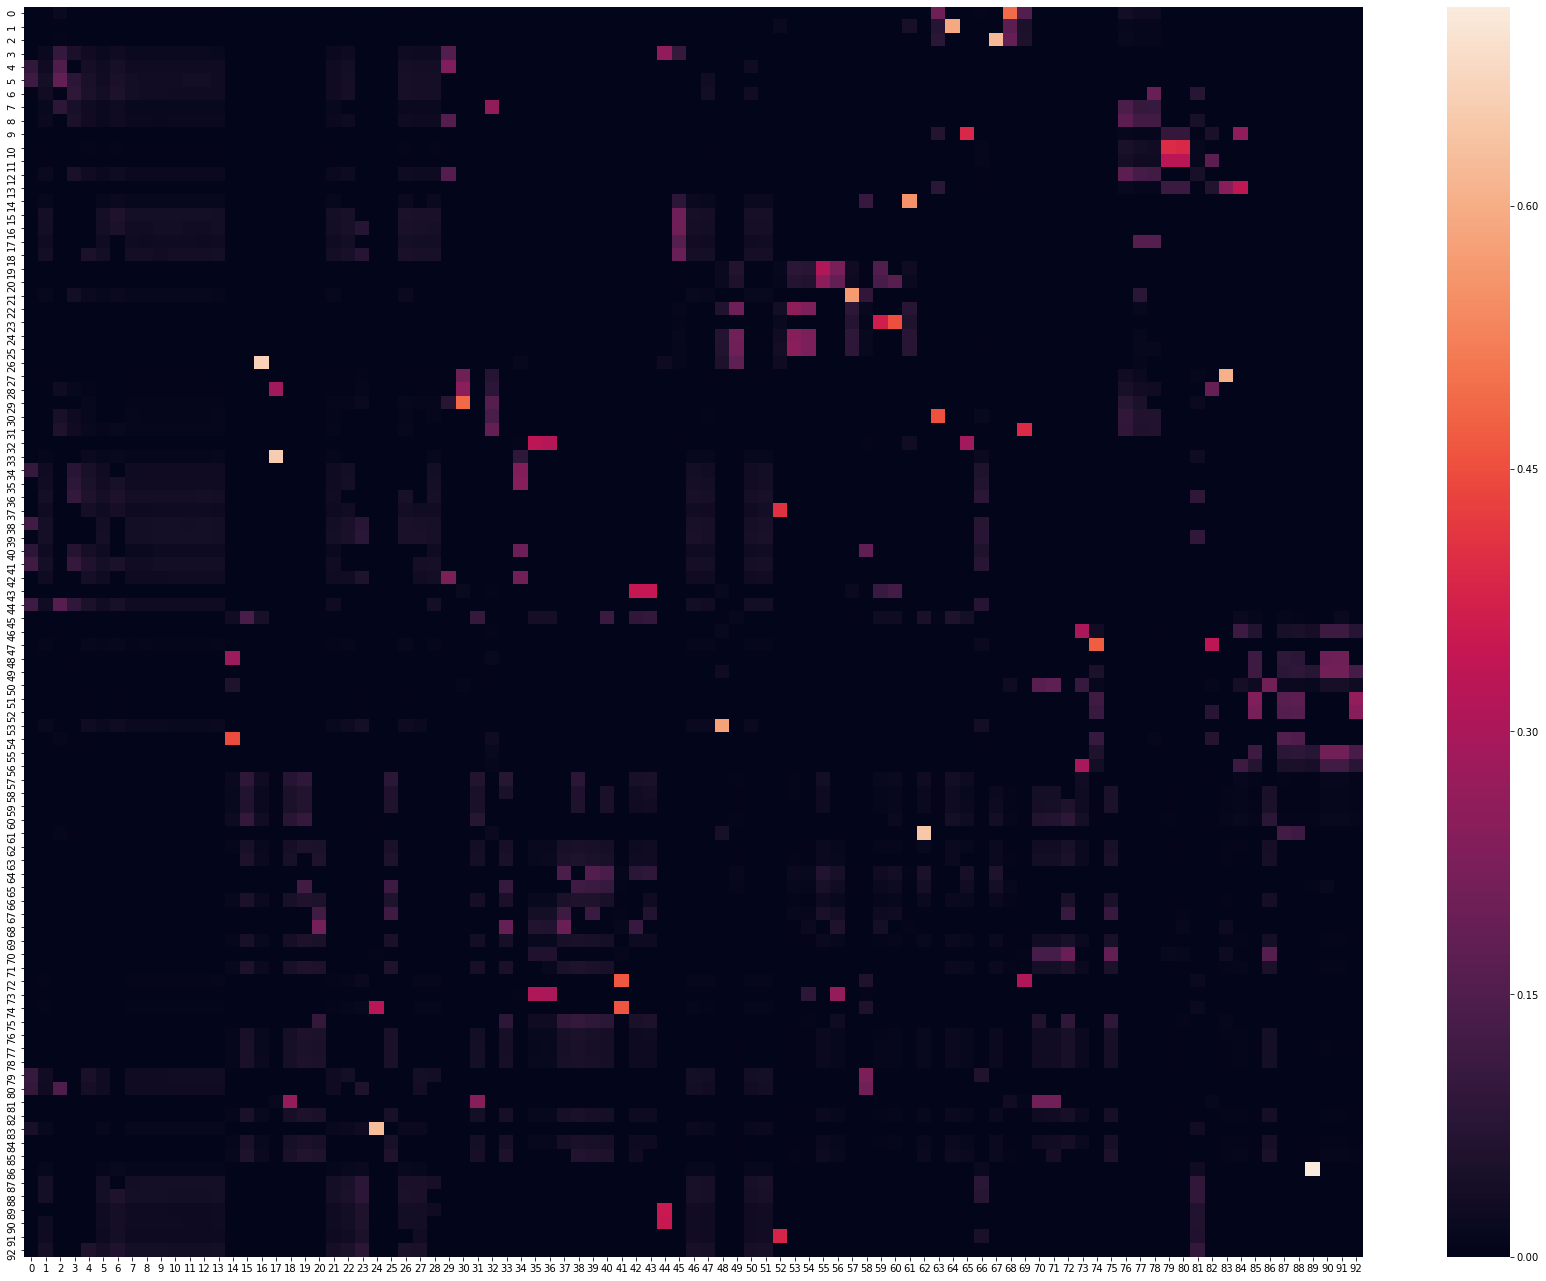

In [56]:
fig = plt.figure(figsize=(30,23))
adj = graph_utils.apply_doubly_stochastic(not_normal_adj)
sns.heatmap(adj)
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/dat/fig/double_stochastic_new.pdf")

In [ ]:
# tmp1 = graph_utils.keep_k_percentile_of_each_row(int_mat, percentile)
# tmp1 = int_mat.where(tmp1>0, 0)
# tmp2 = graph_utils.keep_k_percentile_of_each_col(int_mat, percentile)
# tmp2 = int_mat.where(tmp2>0, 0)
# tmp3 = graph_utils.keep_k_percentile_of_each_col_and_each_row(int_mat, percentile)
# tmp3 = int_mat.where(tmp3>0, 0)

In [64]:
# node_id = '76'
# plt.figure(figsize=(25,5))
# plt.plot(int_mat.loc[node_id], label="row values")
# plt.scatter([i for i in range(93)],tmp1.loc[node_id], c="orange", label="largest row values")
# plt.scatter([i for i in range(93)],tmp3.loc[node_id], c="green", label="largest row and col values", alpha=0.5, marker='x')

# plt.plot([i for i in range(93)], adj.loc[node_id]*10, c="red", label = "final values")
# plt.legend()

In [50]:
# utils.print_whole_df(tmp3)

In [51]:
# utils.print_whole_df(adj)

In [52]:
# soccer = graph_utils.return_soccer_weight_matrix()
# sns.heatmap(soccer)
# soccer

In [53]:
# graph_utils.apply_doubly_stochastic(soccer)

In [54]:
# sns.heatmap(graph_utils.apply_doubly_stochastic(soccer))

## Walk on the extended npp adj

In [15]:
edges = graph_utils.build_edge_list(weight_matrix=adj, threshold=None, directed=True)
nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# 2) Create stellar Di graphs
sdg = StellarDiGraph(nxg)
BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)
rw = BDWW.BiasedDirectedRandomWalk(sdg, directed=True, weighted=True, begin_checks=False)

nodes = list(sdg.nodes())
walks = rw.run(nodes=nodes, length=100, n=100, p=1, q=1, weighted=True, directed=True)

utils.write_list_of_lists_to_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/all_test_walks/Dynamic_neighbor_walk_inh_exc_cAMP_40percentile_100_100.csv", walks)

Building a directed graph edge list
Checking all the weights on all the edges!
Computing the node importance!
Done writing!


In [53]:
prefix = "Dynamic_neighbor_walk_extended_npp_run9"
finished_epoch = 2900 + 100
nandcg_E = []
nandcg_R = []
for e in range(100, finished_epoch, 100):
    epoch = e
    n_emb = 5

    E = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/run_results/" + 
                    prefix + "_" + str(epoch) + "_E_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")
    R = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/run_results/" + 
                    prefix + "_" + str(epoch) + "_R_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")

    E.index = E.index.astype(str)
    R.index = R.index.astype(str)

    E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(E[["Z" + str(i) for i in range(n_emb)]], 
                                                                                        R[["Z" + str(i) for i in range(n_emb)]])
    nandcg_E.append(analysis.Compute_node_average_ndcg(adj=adj, e_to_r=E_to_R_dist, k=7))   
    nandcg_R.append(analysis.Compute_node_average_ndcg(adj=adj.T, e_to_r=E_to_R_dist.T, k=7))   

#     similarity = analysis.get_similarity_from_distance_matrix(E_to_R_dist) 
#     predictions = analysis.get_predictions_correct_format_for_precision_recall_function(estimated_relevance=similarity, 
#                                                                                         true_relevance=adj)
#     precisions, recalls, sorted_user_est_true= analysis.precision_recall_at_k(predictions, k=7)
#     prec.append(sum(precisions.values())/len(precisions))

In [75]:
emit, rece = analysis.summarize_embedding_results(E, R, "cluster_label", cldf)

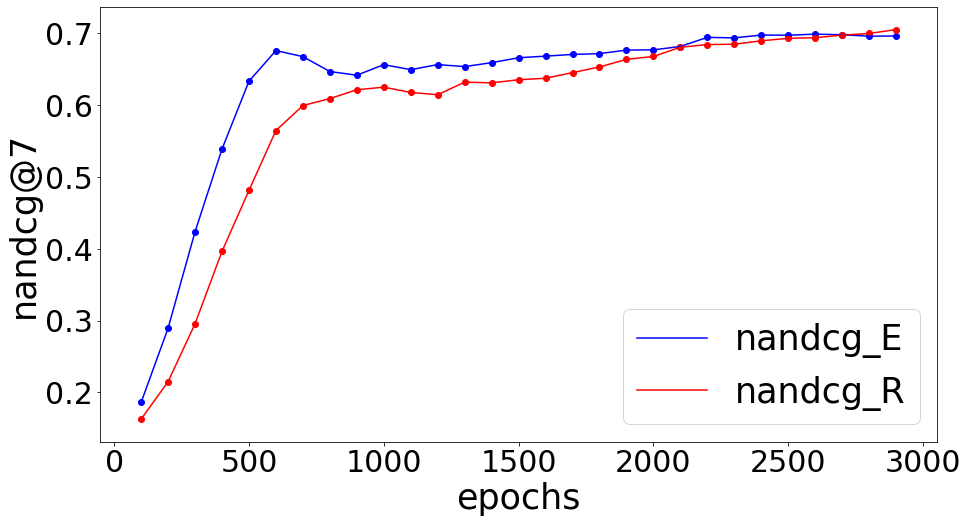

In [70]:
fig = plt.figure(figsize=(15,8))
plt.scatter([i for i in range(100, finished_epoch, 100)],nandcg_E, color='blue')
plt.plot([i for i in range(100, finished_epoch, 100)], nandcg_E, color='blue', label='nandcg_E')
plt.scatter([i for i in range(100, finished_epoch, 100)],nandcg_R, color='red')
plt.plot([i for i in range(100, finished_epoch, 100)], nandcg_R, color='red', label='nandcg_R')
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel("epochs", size=35)
plt.ylabel("nandcg@7", size=35)
plt.legend(fontsize=35)
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/dat/fig/nandcg.pdf")

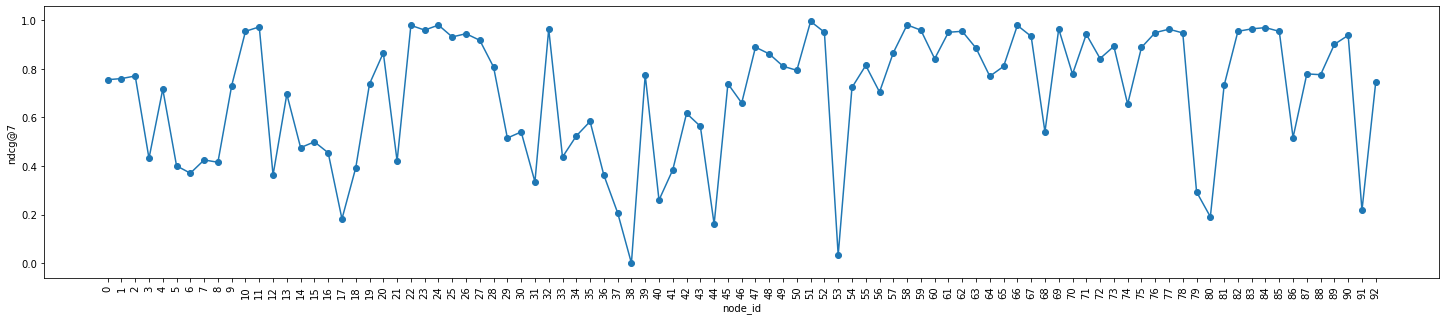

In [74]:
# %matplotlib qt
ndcg_E, _ = plot_utils.plot_node_average_ndcg(adj=adj, e_to_r=E_to_R_dist, k=7, figsize=(25,5))
#ndcg_R, _ = plot_utils.plot_node_average_ndcg(adj=adj.T, e_to_r=E_to_R_dist.T, k=7, figsize=(25,5))

In [30]:
# plot_utils.plot_multiple_dict({'ndcg_E':ndcg_E, 'ndcg_R':ndcg_R})

In [66]:
# similarity = analysis.get_similarity_from_distance_matrix(E_to_R_dist)
# predictions = analysis.get_predictions_correct_format_for_precision_recall_function(estimated_relevance=similarity, 
#                                                                                     true_relevance=adj)
# precisions, recalls, sorted_user_est_true= analysis.precision_recall_at_k(predictions, k=7)

# plot_utils.plot_dict(precisions, "node_ids", "precisions@7", 90, order_of_x_values=adj.index.tolist())
# plot_utils.plot_dict(recalls, "node_ids", "precisions", 90)

In [13]:
#%matplotlib inline
# node_id ='62'
# node_act="E"
# emi_df, rec_df = plot_utils.plot_closest_nodes(node_id = node_id, E=E, R=R, adj=adj, topn=5, n_emb=3, node_act=node_act, cldf=cldf,
#                                       resolution="cluster_label", plot_dim=3, scatter_point_size=100, alpha=1, 
#                                       plot_size=(10, 10), annotation=True, theta1=30, theta2=30, xlim=None, ylim=None, zlim=None)

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv
Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


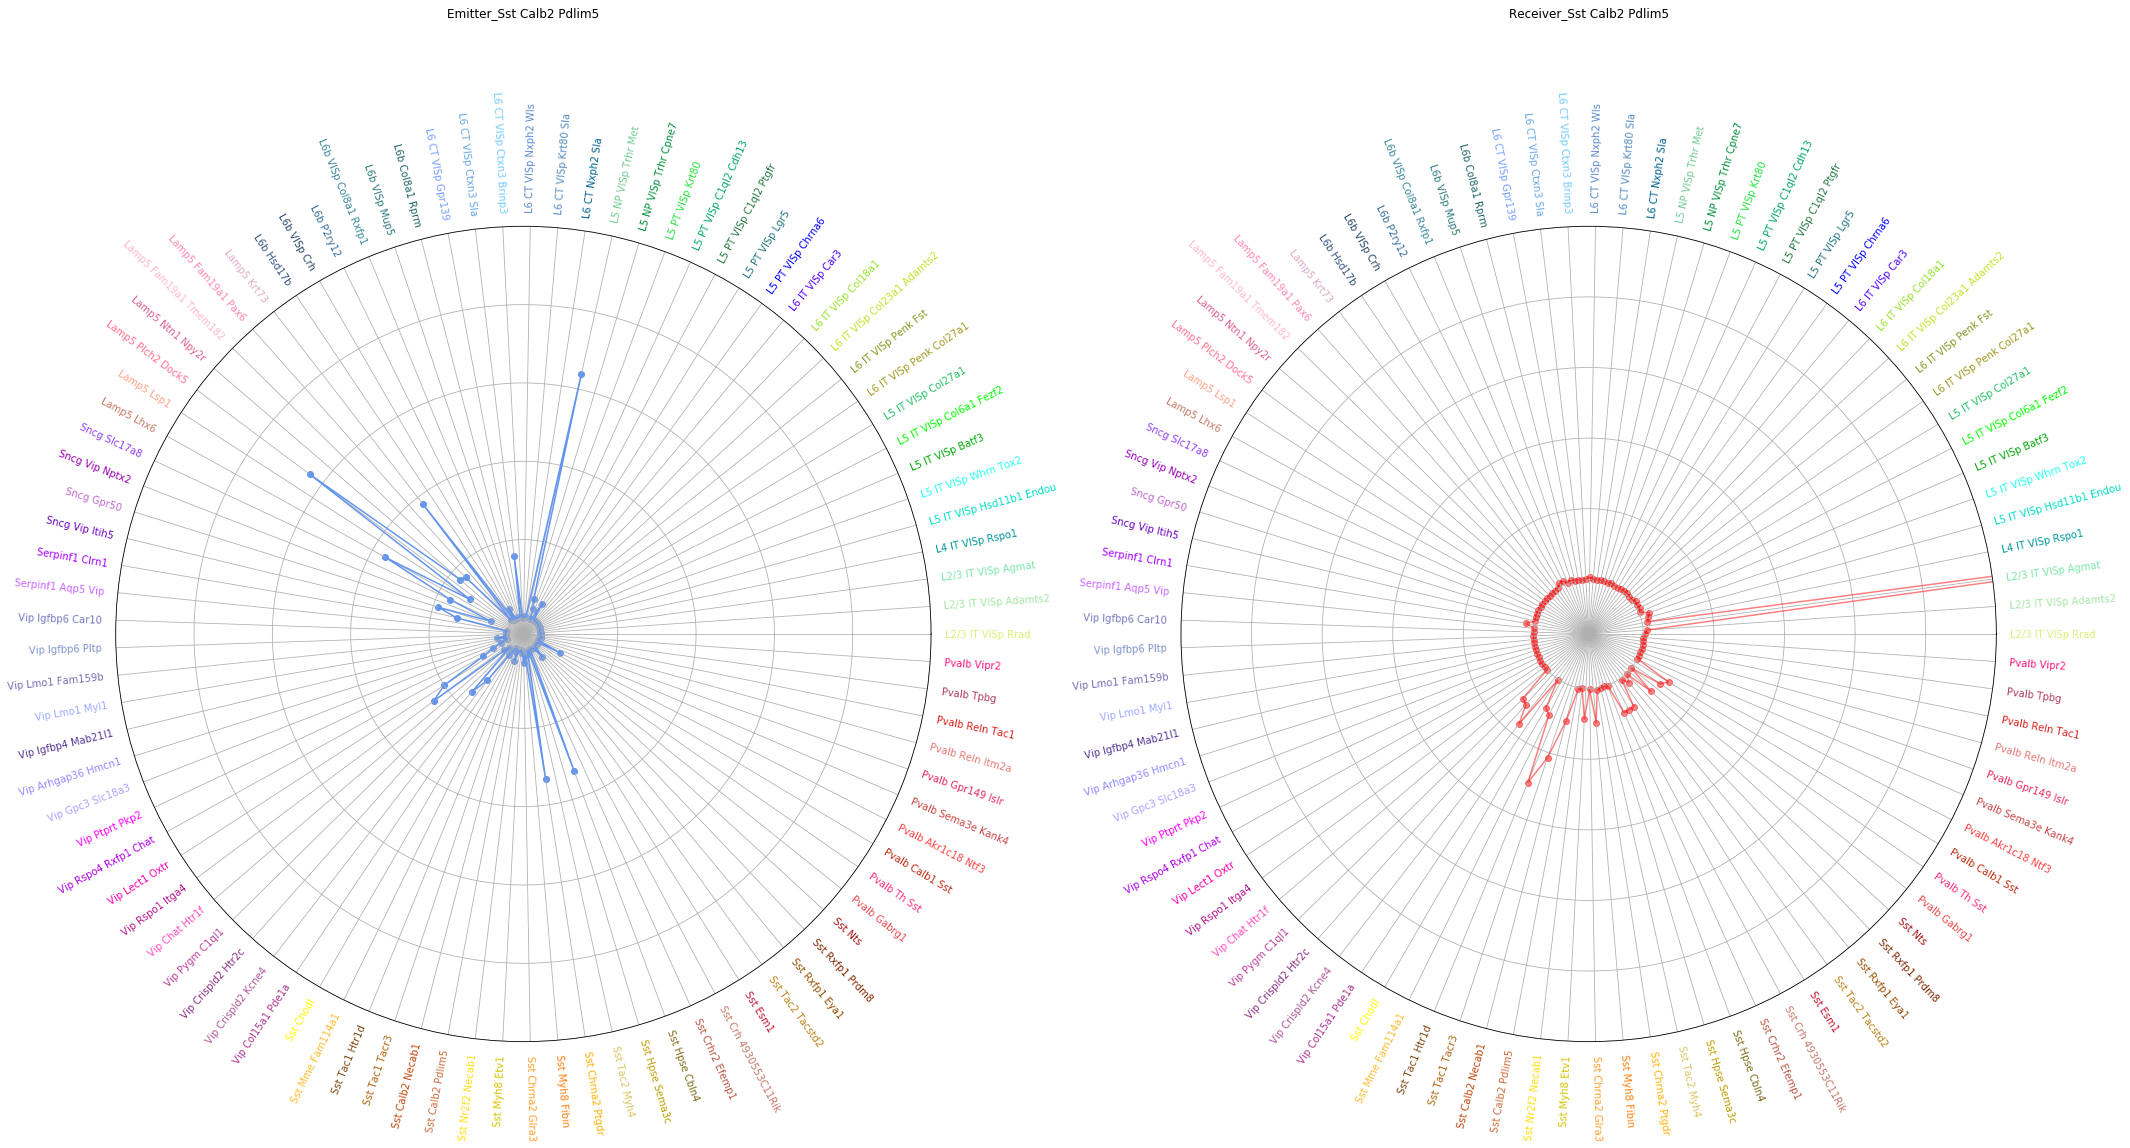

In [147]:
##### %matplotlib inline
node_id = '67'
colors = utils.read_visp_npp_cldf("old")['cluster_color'].tolist()
types = utils.read_visp_npp_cldf("old")['cluster_label'].tolist()
Katz = analysis.Katz_proximity(adj, beta = 0.05)
U_s, U_t = analysis.nmf_factorization(Katz, n_components=35)
s_to_t, t_to_s = analysis.return_right_left_similarity(U_s, U_t)
theta = graph_utils.return_theta(93)
fig = plot_utils.plot_polar_source_target_relation(theta, 
                                                   r1=s_to_t[int(node_id)], 
                                                   r2=t_to_s[int(node_id)], 
                                                   title=types[int(node_id)],
                                                   rmax = 0.01,
                                                   xtick_label_colors=colors, 
                                                   xtick_labels=types,
                                                   plot_size=(35, 15))

In [148]:
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/dat/fig/polar_plot.pdf")

In [227]:
#node_id = '91'
node_label = None
node_act = 'E'
analysis.get_closest_nodes_info(node_label=node_label, 
                                node_id=node_id,
                                E_to_R_dist=E_to_R_dist, 
                                adjacency=adj, 
                                topn=7, 
                                cldf=cldf, 
                                resolution="cluster_label", 
                                node_action=node_act)


Closet neighbors of cluster_label Sst Mme Fam114a1
______________________________________


,predicted_neighbors_weights,predicted_closest_neighbors_index,predicted_closest_neighbors_label,Actual_neighbor_weights,Actual_neighbor_index,Actual_neighbor_label,match
0,0.0508,25,L6 CT VISp Ctxn3 Sla,0.0537,19,L5 NP VISp Trhr Cpne7,1
1,0.0496,38,Lamp5 Lsp1,0.0508,25,L6 CT VISp Ctxn3 Sla,1
2,0.0436,40,Sncg Slc17a8,0.0504,20,L5 NP VISp Trhr Met,1
3,0.0445,39,Lamp5 Lhx6,0.0499,72,Sst Chrna2 Ptgdr,1
4,0.0504,20,L5 NP VISp Trhr Met,0.0496,38,Lamp5 Lsp1,1
5,0.0537,19,L5 NP VISp Trhr Cpne7,0.0476,15,L5 PT VISp Lgr5,0
6,0.0499,72,Sst Chrna2 Ptgdr,0.0455,37,Lamp5 Plch2 Dock5,0


In [228]:
node_act = 'R'
# node_id = '62'
# node_label = None
analysis.get_closest_nodes_info(node_label=node_label, 
                                node_id=node_id,
                                E_to_R_dist=E_to_R_dist, 
                                adjacency=adj, 
                                topn=7, 
                                cldf=cldf, 
                                resolution="cluster_label", 
                                node_action=node_act)


Closet neighbors of cluster_label Sst Mme Fam114a1
______________________________________


,predicted_neighbors_weights,predicted_closest_neighbors_index,predicted_closest_neighbors_label,Actual_neighbor_weights,Actual_neighbor_index,Actual_neighbor_label,match
0,0.1919,0,L2/3 IT VISp Rrad,0.4024,30,L6b P2ry12,1
1,0.0000,27,L6b Col8a1 Rprm,0.1919,0,L2/3 IT VISp Rrad,1
2,0.0861,1,L2/3 IT VISp Adamts2,0.0941,2,L2/3 IT VISp Agmat,1
3,0.4024,30,L6b P2ry12,0.0861,1,L2/3 IT VISp Adamts2,1
4,0.0941,2,L2/3 IT VISp Agmat,0.0790,9,L6 IT VISp Penk Col27a1,0
5,0.0000,31,L6b VISp Crh,0.0640,13,L6 IT VISp Car3,0
6,0.0000,28,L6b VISp Mup5,0.0099,45,Serpinf1 Aqp5 Vip,0


In [89]:
emb_umap = analysis.Compute_umap(pd.concat((emit, rece)), 5)

<Figure size 576x576 with 0 Axes>

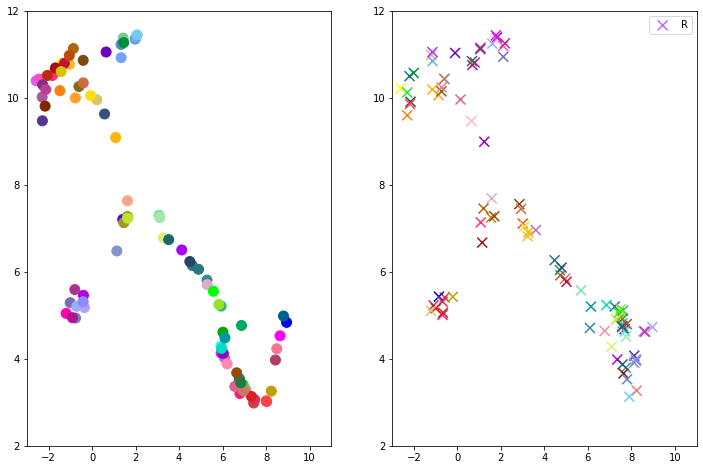

In [101]:
emb_umap = analysis.Compute_umap(pd.concat((emit, rece)), 5)
em = emb_umap[emb_umap['node_act']=="E"]
em = em.set_index('cluster_id')

re = emb_umap[emb_umap['node_act']=="R"]
re = re.set_index('cluster_id')

fig = plt.figure(figsize=(8,8))

# em = emit
# re = rece
fig = plot_utils.plot_ER(emitter=em, 
                   receiver=re, 
                   figsize=(12,8), 
                   plot_dim=2, 
                   annotation=False, 
                   annotation_label="cluster_label",
                   E_marker='o', 
                   R_marker='x', 
                   resolution="cluster_label",
                   side_by_side=True, 
                   scatter_point_size=100,
#                    E_sublist_to_color=em[em['cluster_label']=="Sst Myh8 Etv1"],
#                    R_sublist_to_color=re[re['cluster_label']=="Sst Myh8 Etv1"],
                   xlim=(-3, 11),
                   ylim=(2, 12), 
#                    zlim=(-8,8),
                  )



In [193]:
cldf[cldf['subclass_label']=="Sst C"]

,dendcluster_id,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color
cluster_id,,,,,,,,,,
62,85,Sst Chodl,#FFFF00,#FFFF00,5,Sst,#F15A29,1,GABAergic,#EF4136
63,86,Sst Mme Fam114a1,#FFBB33,#FFBB33,5,Sst,#F15A29,1,GABAergic,#EF4136
64,87,Sst Tac1 Htr1d,#804811,#804811,5,Sst,#F15A29,1,GABAergic,#EF4136
65,88,Sst Tac1 Tacr3,#B06411,#B06411,5,Sst,#F15A29,1,GABAergic,#EF4136
66,89,Sst Calb2 Necab1,#BF480D,#BF480D,5,Sst,#F15A29,1,GABAergic,#EF4136
67,90,Sst Calb2 Pdlim5,#CC6D3D,#CC6D3D,5,Sst,#F15A29,1,GABAergic,#EF4136
68,91,Sst Nr2f2 Necab1,#FFDF11,#FFDF11,5,Sst,#F15A29,1,GABAergic,#EF4136
69,92,Sst Myh8 Etv1,#D6C300,#D6C300,5,Sst,#F15A29,1,GABAergic,#EF4136
70,93,Sst Chrna2 Glra3,#FF9F2C,#FF9F2C,5,Sst,#F15A29,1,GABAergic,#EF4136


In [104]:
# adj_exc_cAMP = adj
# E_to_R_dist_exc_cAMP = E_to_R_dist
# E_exc_cAMP = E
# R_exc_cAMP = R
# emit_exc_cAMP = emit
# rece_exc_cAMP = rece

# adj_inh_cAMP = adj
# E_to_R_dist_inh_cAMP = E_to_R_dist
# E_inh_cAMP = E
# R_inh_cAMP = R
# emit_inh_cAMP = emit
# rece_inh_cAMP = rece

# adj_all_cAMP = adj
# E_to_R_dist_all_cAMP = E_to_R_dist
# E_all_cAMP = E
# R_all_cAMP = R
# emit_all_cAMP = emit
# rece_all_cAMP = rece

In [91]:
kmeans = KMeans(n_clusters=12, random_state=0).fit(np.array(comb[["Z" + str(i) for i in range(n_emb)]]))

In [92]:
comb['kmean'] = kmeans.labels_

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(comb[comb['kmean']==0]['Z0'], comb[comb['kmean']==0]['Z1'], comb[comb['kmean']==0]['Z2'], c='black')
ax.scatter(comb[comb['kmean']==1]['Z0'], comb[comb['kmean']==1]['Z1'], comb[comb['kmean']==1]['Z2'], c='red')
ax.scatter(comb[comb['kmean']==2]['Z0'], comb[comb['kmean']==2]['Z1'], comb[comb['kmean']==2]['Z2'], c='green')
ax.scatter(comb[comb['kmean']==3]['Z0'], comb[comb['kmean']==3]['Z1'], comb[comb['kmean']==3]['Z2'], c='blue')
ax.scatter(comb[comb['kmean']==4]['Z0'], comb[comb['kmean']==4]['Z1'], comb[comb['kmean']==4]['Z2'], c='orange')


In [102]:
comb[comb['kmean']==0]

,Z0,Z1,Z2,cluster_color,cluster_label,node_act,kmean
cluster_id,,,,,,,
46,-0.5174,-1.5312,-0.6905,#7779BF,Vip Igfbp6 Car10,E,0
50,-0.6763,-1.1382,-0.9239,#533691,Vip Igfbp4 Mab21l1,E,0
55,-0.4549,-1.7059,-0.6466,#FF00B3,Vip Lect1 Oxtr,E,0
56,-0.5001,-1.5217,-0.7076,#B3128A,Vip Rspo1 Itga4,E,0
61,-0.9600,-1.0265,-0.4591,#AC3491,Vip Col15a1 Pde1a,E,0
83,-0.8823,-1.3787,-0.7856,#ED4C50,Pvalb Gabrg1,E,0
86,-0.7012,-1.6204,-0.5542,#FF4343,Pvalb Akr1c18 Ntf3,E,0
14,-0.4832,-1.2308,-0.6003,#0000FF,L5 PT VISp Chrna6,R,0
39,-0.8812,-1.2219,-0.7631,#C77963,Lamp5 Lhx6,R,0
